In [ ]:
#@title
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73
    !pip install tqdm

import os
import random
import mat73
import scipy.io
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
from tensorflow.math import abs, angle, real, imag, subtract, multiply
from scipy.optimize import minimize
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tqdm import tqdm

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

     |████████████████████████████████| 137 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 29.6 MB/s 
     |████████████████████████████████| 209 kB 37.4 MB/s 
     |████████████████████████████████| 12.5 MB 17.0 MB/s 
     |████████████████████████████████| 109 kB 48.4 MB/s 
     |████████████████████████████████| 51 kB 499 kB/s 
     |████████████████████████████████| 251 kB 6.2 MB/s 
     |████████████████████████████████| 546 kB 40.0 MB/s 
     |████████████████████████████████| 462 kB 39.2 MB/s 
  Created wheel for pydeepimagej: filename=pydeepimagej-2.3.3-py3-none-any.whl size=24230 sha256=0de11aa732f731d862d0c298bddb55cec3f0518adbd85a0fa6897e6fa687487a
  Stored in directory: /root/.cache/pip/wheels/4a/05/98/e4bba4aca59759f5e635d6de7d953a9c60a3db586dd2d96dee
Successfully built pydeepimagej
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
E

In [ ]:
#@title
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape=[64,64]):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg
#http://edge.rit.edu/edge/P13051/public/Research%20Notes/refractive%20index%20glycerin%20water.pdf

In [ ]:
def extract_pos_and_images(data):
    """Saves images and positions for individual particles."""
    particles_timeseries = []
    particles_positions = []
    num_particles = data.shape[1]

    for i in tqdm(range(num_particles)):
        positions = data[0,i][0,0]["Positions"][:,1:4]
        particles_positions.append(positions)
        roi_data = np.array(data[0,i][0,0]["ROI"])

        timeseries = []
        for j in range(roi_data[0,0].shape[0]):
            particleROI = np.expand_dims(np.fft.fftshift(np.fft.ifft2(exp_expand(roi_data[0,0][j,:], [64,64]))), axis = -1)
            timeseries.append(particleROI)
        particles_timeseries.append(np.array(timeseries))
    return particles_positions, particles_timeseries

In [ ]:
""" Function used to divide the whole image into tiles """

no_tiles = 9
def whichTile(x_cor, IMAGE_SIZE = (1450, 1930), tiles = (1, 9)):

    map = np.reshape(np.arange(0, tiles[0] * tiles[1]), tiles)
    colSplit = np.cumsum([IMAGE_SIZE[1] // tiles[1] + (1 if x < IMAGE_SIZE[1] % tiles[1] else 0)  for x in range (tiles[1])])
    colSeg = sum(colSplit < x_cor)

    return map[0, colSeg]

def segment_exp_data(particles_positions, particles_timeseries):
  particles_positions_seg = [None] * no_tiles
  particles_timeseries_seg = [None] * no_tiles

  # Find mean x-coordinate of a trace and use this to choose a tile
  mean_xcor = list(map(lambda x: np.mean(x[:, 0] / 0.114), particles_positions))
  choosen_tile = list(map(whichTile, mean_xcor))

  # Might be faster without loop but this is a quick (and ugly) solution
  for ind, tile in enumerate(choosen_tile):

    if (particles_positions_seg[tile] is None):
      particles_positions_seg[tile] = []
      particles_timeseries_seg[tile] = []


    particles_positions_seg[tile].append(particles_positions[ind])
    particles_timeseries_seg[tile].append(particles_timeseries[ind])

  # To index into returned results:
  # Results = ([pos or timeseries])[tile][trace][row, col of trace]
  return particles_positions_seg, particles_timeseries_seg


In [ ]:
"""Create group/equivariance"""


def create_group(crop_size=64, padding=16, wavelength=525e-9, pixel_size=114e-9):
    crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size, wavelength)
    crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size, wavelength)

    args = dt.Arguments(
        translate=lambda: np.random.randn(2)*0.5,
        rotate=lambda: np.random.uniform(0, np.pi*2),
        z=lambda: np.random.randn(1)*5,
    )

    group = ( 
        dt.Affine(rotate=args.rotate) 
        >> dt.Affine(translate=args.translate) 
        >> dt.FourierTransform(padding=padding) 
        >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z, padding=padding) 
        >> dt.InverseFourierTransform(padding=padding) 
    )

    equivariance = (
        dt.models.lodestar.Rotational2DEquivariance(args.rotate)
        >> dt.models.lodestar.TranslationalEquivariance(args.translate)
        >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
    )

    return group, equivariance

def create_training_set(particles_timeseries):
    imgs = []
    for particle_id in range(0,len(particles_timeseries),1):
        img = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        img = img[0,:,:,:]
        imgs.append(img)

    # Altered to train only on 8 images (sort to avoid images with multiple particles)
    imgs.sort(key = lambda x : np.sum(x[:, :, 1]))
    imgs = imgs[int(len(imgs)/2) - 4:int(len(imgs)/2)+4]
    print(len(imgs))
    return dt.Value(lambda: random.choice(np.array(imgs)))

def plot_dataset(dataset, group, nrows=3, ncols=10):
    for _ in range(nrows):
        fig, axs = plt.subplots(1,ncols,figsize=(25,8))
        for i in range(ncols):
          axs[i].imshow((dataset>>group).update()()[..., 1])
        plt.show()


In [ ]:
"""Create custom layers"""
class CustomLayer(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [ ]:
"""Create models"""
def create_model(custom_layer, nlayers, image_size):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(image_size,image_size,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(64, 3, activation='relu', strides=(2,2)))
    for _ in range(nlayers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": nlayers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model


In [ ]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = cycler(color=list('bgrcmyk'))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()


In [ ]:
def save_models(model_list, save_model_path):
  for i, model in enumerate(model_list):
    model.save_weights(save_model_path + f"model{i}")

def load_models(path, num_models, image_size):
  model_list = []
  for i in range(num_models):
    model = create_model(CustomLayer(), 2, image_size)
    model.load_weights(path + f"model{i}")
    model_list.append(model)

  return model_list

In [ ]:
def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets, val_stack.shape[2])
    return dets

def reshape_dets(dets, image_size):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = image_size//2, image_size//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

"""
def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]
"""

'\ndef create_validation_stack(images, z_list):\n    \n    output = []\n    for i in range(images.shape[0]):\n        image = images[i,:,:,:]\n        stack = []\n        for z in z_list:\n            stack.append(propagate(image, z))\n        output.append(stack)\n    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]\n'

In [ ]:
def calc_sigma2(arr):
    sigma2 = -np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            ))
    return sigma2

In [ ]:

def train_on_particle(model, particle):
    training_set = create_training_set(particle)

    generator = dt.models.lodestar.LodeSTARGenerator(
        training_set,
        num_outputs=num_outputs, 
        transformation_function=(group, equivariance), 
        batch_size=8, 
        min_data_size=100, 
        max_data_size=101,
    )

    for _ in tqdm(range(10)):
        with generator:
            h = model.fit(generator, epochs=10, steps_per_epoch=100, verbose=0)


# Altered to work with several models operating on different segments of the image
def compare_lode_matlab(list_of_models, particles, particles_positions,  verbose=1):

    # Choose which model to use for prediction
    mean_xcor = list(map(lambda x: np.mean(x[:, 0] / 0.114), particles_positions))
    choosen_tile = list(map(whichTile, mean_xcor))


    z_mults = []
    traces_matlab = []
    traces_lode = []

    for i, particle_id in enumerate(tqdm(range(len(particles)))):

        timeseries = np.stack((np.real(particles[particle_id][:,:,:,0]), np.imag(particles[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(list_of_models[choosen_tile[i]], timeseries)

        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], 1.5*particles_positions[particle_id][:,2]

        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(x_lode-32)*0.114, y_matlab+(y_lode-32)*0.114, z_matlab+z_lode # byt ut mot pixel_sizez!

        z_mult = minimize(lambda x: np.abs(calc_sigma2(z_matlab + z_lode*x)), [0], method="Powell").x
        z_mult = np.median([-10,z_mult,10]) #reducing the effect of very strange values

        if verbose:
            print("PARTICLE ID:", particle_id, end="  ")
            print(f"z_mult: {z_mult:.3f}, sigma2_new/sigma2_matlab: {calc_sigma2(z_new)/calc_sigma2(z_matlab):.2f}")

            if particle_id%10==0:
                fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
                ax1.plot(x_matlab, 'b')
                ax1.plot(x_new, 'r')
                ax1.set_xlabel("x")

                ax2.plot(y_matlab, 'b')
                ax2.plot(y_new, 'r')
                ax2.set_xlabel("y")

                ax3.plot(z_matlab, 'b')
                ax3.plot(z_new, 'r')
                ax3.set_xlabel("z")
                plt.show()

        z_mults.append(z_mult)
        traces_matlab.append(np.array([x_matlab, y_matlab, z_matlab]))
        traces_lode.append(np.array([x_lode*0.114, y_lode*0.114, z_lode]))

    return traces_matlab, traces_lode, z_mults

In [ ]:
def plot_diffusion(Dx, Dz, colors, title):
    range=(-2,6)
    nbins=25
    plt.figure(figsize=(5, 4))

    plt.hist(Dx, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[0]], label="In-plane diffusion")
    plt.hist(Dz, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[1]], label="Vertical diffusion")
    
    plt.axvline(np.median(Dx), c=seaborn.color_palette("colorblind")[colors[0]], linestyle="--", label="Median")
    plt.axvline(np.median(Dz), c=seaborn.color_palette("colorblind")[colors[1]], linestyle="--", label="Median")
    plt.title(title)
    plt.legend()
    plt.show()
    print(f"nz/nx = sqrt(Dz/Dx) {np.sqrt(np.median(Dz)/np.median(Dx)):.3f}")

def calculate_diffusion(traces, shortest_trace=20):
    _traces = [trace for trace in traces if trace.shape[1]>shortest_trace]

    #Ekvation 16
    sigma_x2 = np.array([calc_sigma2(trace[0,:]) for trace in _traces])
    sigma_z2 = np.array([calc_sigma2(trace[2,:]) for trace in _traces])

    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*sigma_x2[i])
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*sigma_z2[i])
          /(2*delta_time)
          )
    plot_diffusion(D_x, D_z, (9,3), "Ekvation 16, Separata skattningar för sigma")

    #Ekvation 16 (medelvärdet av sigma)
    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*np.median(sigma_x2))
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*np.median(sigma_z2))
          /(2*delta_time)
          )
    plot_diffusion(D_x, D_z, (9,3), "Ekvation 16, Medelvärdet av alla sigma")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading file: 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 300/300 [00:13<00:00, 22.53it/s]


Training model 0
8


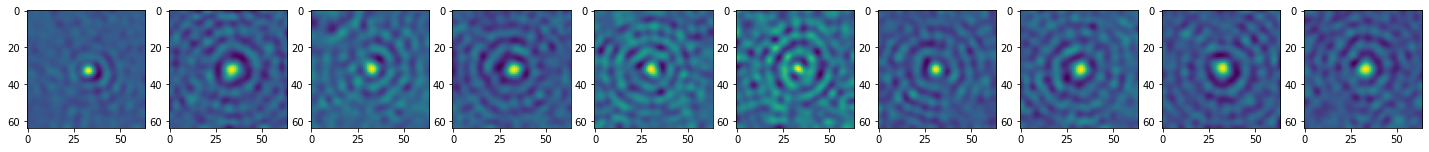

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:42<06:23, 42.66s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:02<03:55, 29.41s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:22<02:54, 24.90s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:42<02:17, 22.91s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [02:02<01:49, 21.84s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [02:18<01:20, 20.13s/it]

Generating 101 / 100 samples before starting training


 70%|███████   | 7/10 [02:35<00:57, 19.12s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [02:56<00:39, 19.70s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [03:19<00:20, 20.68s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [03:39<00:00, 21.90s/it]


Training model 1
8


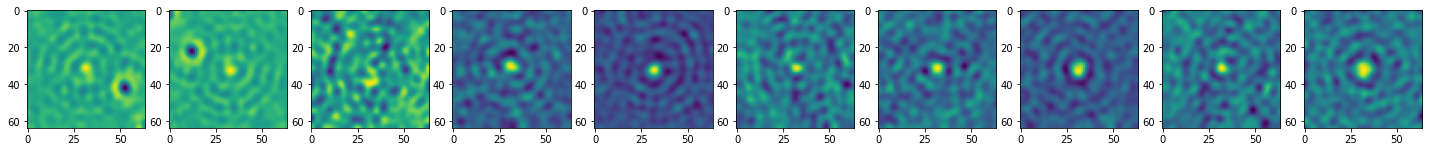

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:44<06:42, 44.77s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:01<03:48, 28.50s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:21<02:52, 24.58s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:41<02:16, 22.70s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [02:01<01:49, 21.81s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [02:23<01:27, 21.82s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:40<01:00, 20.15s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [02:58<00:38, 19.50s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:16<00:18, 18.88s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [03:35<00:00, 21.51s/it]


Training model 2
8


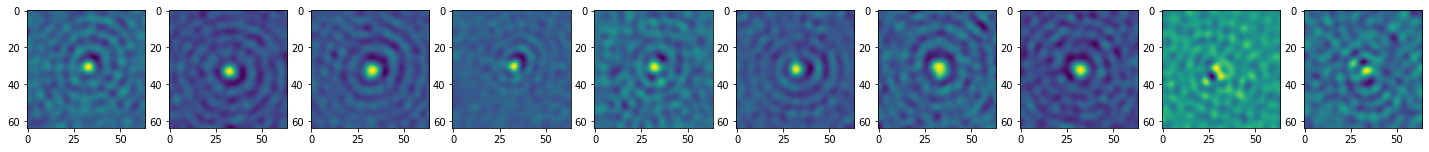

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:45<06:45, 45.07s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:03<03:55, 29.48s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:22<02:52, 24.66s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:43<02:19, 23.19s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [02:01<01:47, 21.49s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:19<01:20, 20.22s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:38<00:58, 19.60s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [02:55<00:37, 18.81s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [03:17<00:19, 19.92s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:37<00:00, 21.72s/it]


Training model 3
8


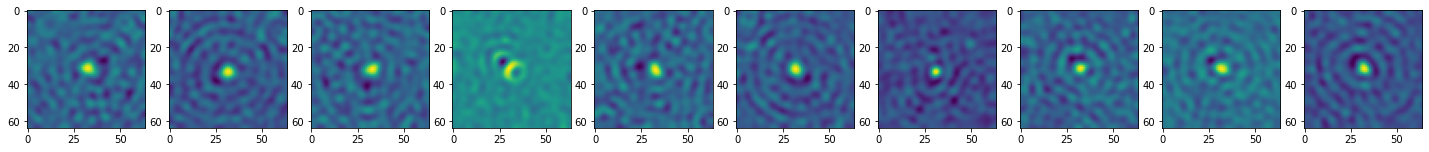

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:44<06:39, 44.39s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:02<03:53, 29.20s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:21<02:51, 24.48s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:40<02:13, 22.32s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [01:56<01:39, 19.93s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:14<01:16, 19.17s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:35<00:59, 19.82s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [02:53<00:38, 19.24s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [03:12<00:19, 19.16s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [03:33<00:00, 21.35s/it]


Training model 4
8


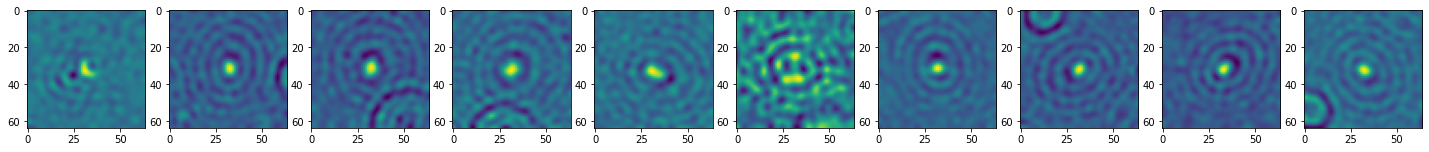

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:46<07:02, 46.90s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:04<03:59, 29.91s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:22<02:51, 24.50s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:40<02:11, 21.86s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [02:00<01:45, 21.17s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [02:19<01:21, 20.41s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:37<00:59, 19.72s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [02:58<00:39, 19.83s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:16<00:19, 19.36s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:36<00:00, 21.66s/it]


Training model 5
8


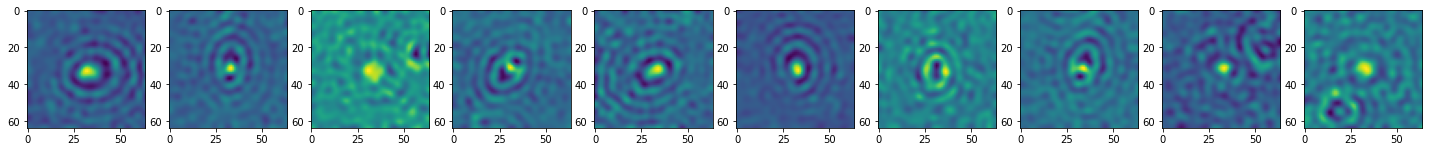

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:47<07:10, 47.86s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:05<04:02, 30.30s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:26<03:02, 26.07s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:46<02:20, 23.36s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [02:03<01:45, 21.09s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:21<01:20, 20.10s/it]

Generating 101 / 100 samples before starting training


 70%|███████   | 7/10 [02:39<00:58, 19.43s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [03:00<00:39, 19.89s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:20<00:19, 19.90s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:41<00:00, 22.15s/it]


Training model 6
8


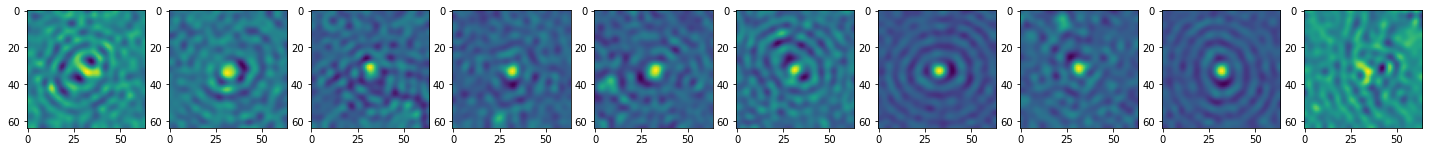

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:51<07:39, 51.06s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [01:11<04:24, 33.00s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:33<03:15, 27.99s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:52<02:26, 24.39s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [02:11<01:53, 22.66s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:30<01:25, 21.34s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:50<01:02, 20.69s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [03:08<00:39, 19.99s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [03:25<00:19, 19.04s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:44<00:00, 22.46s/it]


Training model 7
8


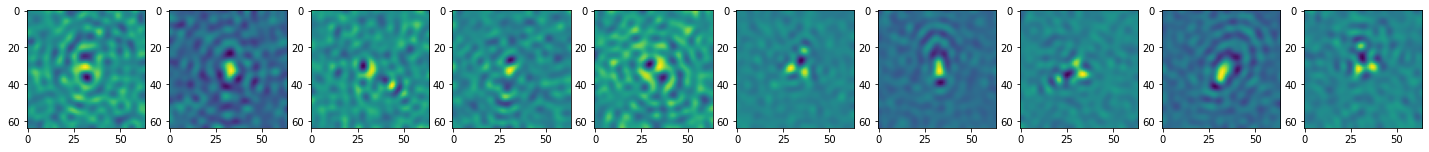

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:54<08:13, 54.79s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [01:13<04:30, 33.83s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:32<03:07, 26.79s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:51<02:23, 23.92s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [02:09<01:47, 21.59s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:30<01:25, 21.50s/it]

Generating 101 / 100 samples before starting training


 70%|███████   | 7/10 [02:49<01:02, 20.77s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [03:11<00:42, 21.01s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [03:30<00:20, 20.52s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:50<00:00, 23.05s/it]


Training model 8
8


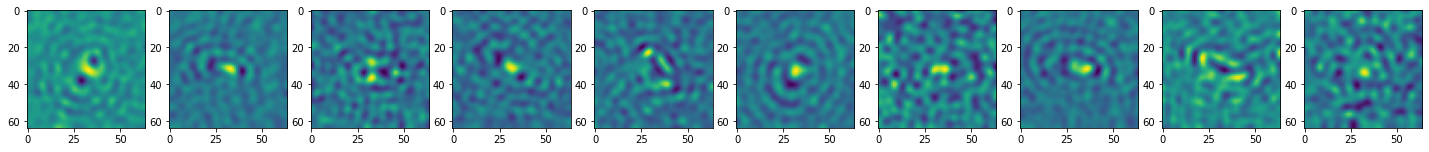

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:50<07:36, 50.70s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:10<04:21, 32.68s/it]

Generating 101 / 100 samples before starting training


 30%|███       | 3/10 [01:27<02:58, 25.55s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:45<02:14, 22.43s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [02:05<01:48, 21.74s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:26<01:25, 21.27s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:44<01:00, 20.15s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [03:04<00:40, 20.20s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:23<00:19, 19.88s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:44<00:00, 22.48s/it]


Creating corrected traces 

 18%|█▊        | 55/300 [00:09<00:47,  5.17it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


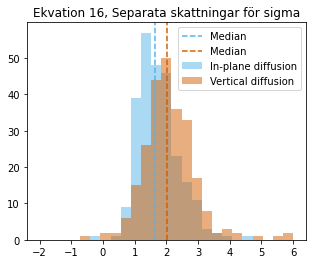

nz/nx = sqrt(Dz/Dx) 1.106


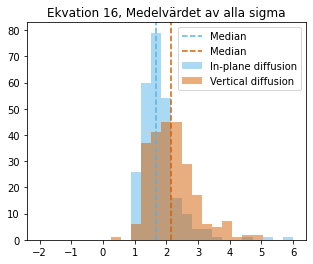

nz/nx = sqrt(Dz/Dx) 1.132
Loading file: 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat 

100%|██████████| 239/239 [00:11<00:00, 21.71it/s]


Training model 0
2


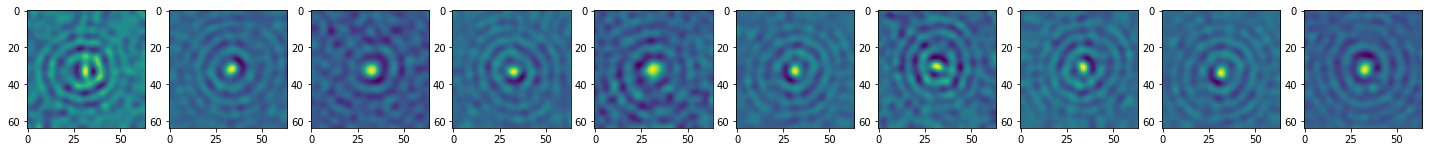

2


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:40<06:05, 40.57s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [01:00<03:47, 28.42s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:20<02:52, 24.69s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:41<02:19, 23.22s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [02:02<01:52, 22.45s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:21<01:24, 21.15s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:41<01:02, 20.78s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [02:57<00:38, 19.31s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:15<00:18, 18.97s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:34<00:00, 21.48s/it]


Training model 1
8


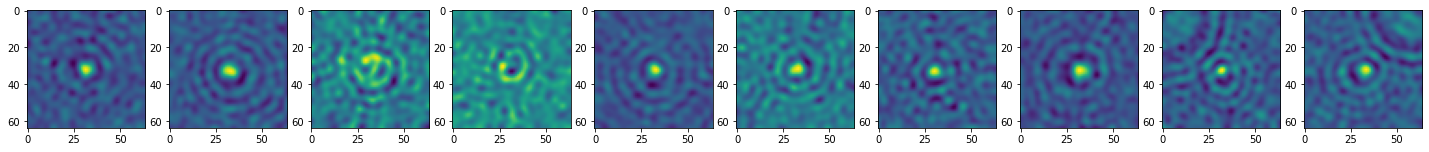

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:43<06:31, 43.53s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:02<03:53, 29.14s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:20<02:48, 24.05s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:40<02:14, 22.44s/it]

Generating 100 / 100 samples before starting training


 50%|█████     | 5/10 [01:58<01:43, 20.73s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [02:20<01:24, 21.11s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:40<01:02, 20.98s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [03:00<00:41, 20.54s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:19<00:20, 20.05s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:38<00:00, 21.85s/it]


Training model 2
8


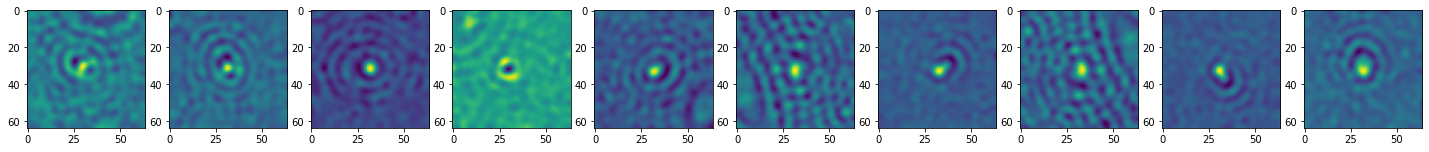

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:41<06:13, 41.50s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [01:00<03:45, 28.16s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:18<02:46, 23.73s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:37<02:11, 21.88s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [01:56<01:43, 20.80s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:15<01:20, 20.09s/it]

Generating 101 / 100 samples before starting training


 70%|███████   | 7/10 [02:34<00:59, 19.74s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [02:54<00:39, 19.85s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:15<00:20, 20.34s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [03:35<00:00, 21.53s/it]


Training model 3
8


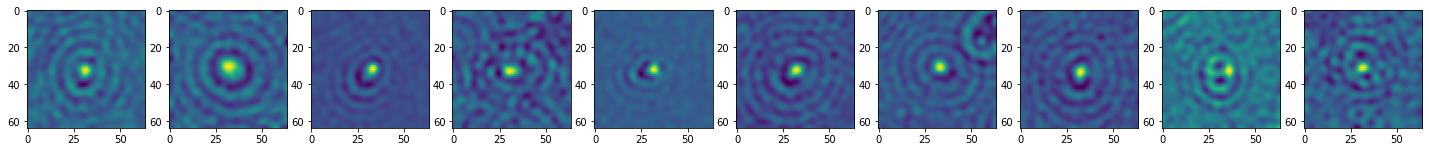

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:43<06:35, 44.00s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [01:03<03:55, 29.49s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:22<02:52, 24.67s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:38<02:08, 21.39s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [01:58<01:44, 20.88s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [02:20<01:24, 21.22s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:38<01:00, 20.19s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [02:58<00:40, 20.23s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [03:17<00:19, 19.58s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:36<00:00, 21.70s/it]


Training model 4
8


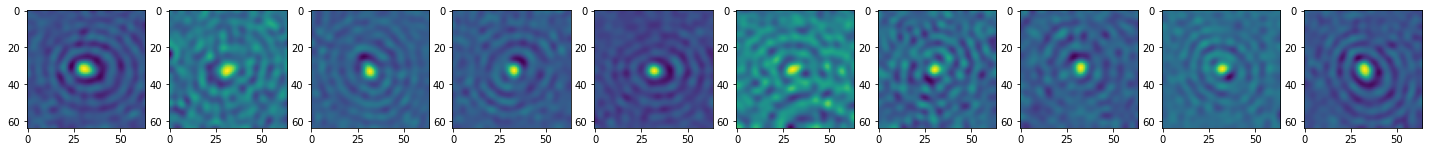

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:43<06:28, 43.20s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [00:59<03:37, 27.21s/it]

Generating 101 / 100 samples before starting training


 30%|███       | 3/10 [01:17<02:43, 23.31s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:38<02:12, 22.09s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [01:58<01:47, 21.42s/it]

Generating 101 / 100 samples before starting training


 60%|██████    | 6/10 [02:17<01:22, 20.61s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:37<01:01, 20.37s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [02:54<00:38, 19.45s/it]

Generating 101 / 100 samples before starting training


 90%|█████████ | 9/10 [03:15<00:19, 19.90s/it]

Generating 101 / 100 samples before starting training


100%|██████████| 10/10 [03:37<00:00, 21.72s/it]


Training model 5
8


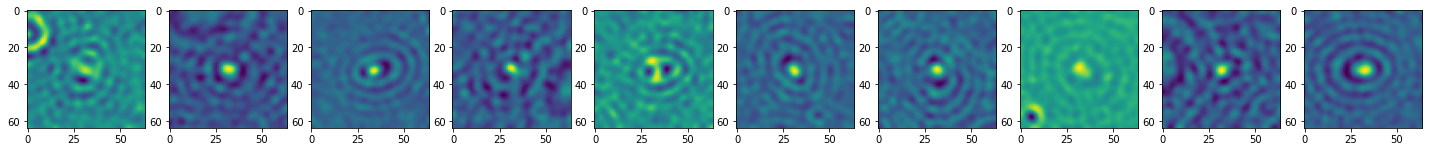

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 101 / 100 samples before starting training


 10%|█         | 1/10 [00:45<06:52, 45.82s/it]

Generating 100 / 100 samples before starting training


 20%|██        | 2/10 [01:03<03:55, 29.42s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:24<02:59, 25.58s/it]

Generating 101 / 100 samples before starting training


 40%|████      | 4/10 [01:41<02:12, 22.13s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [02:01<01:46, 21.35s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [02:21<01:23, 20.89s/it]

Generating 101 / 100 samples before starting training


 70%|███████   | 7/10 [02:40<01:00, 20.31s/it]

Generating 100 / 100 samples before starting training


 80%|████████  | 8/10 [02:56<00:37, 18.85s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:15<00:18, 18.86s/it]

Generating 100 / 100 samples before starting training


100%|██████████| 10/10 [03:34<00:00, 21.43s/it]


Training model 6
8


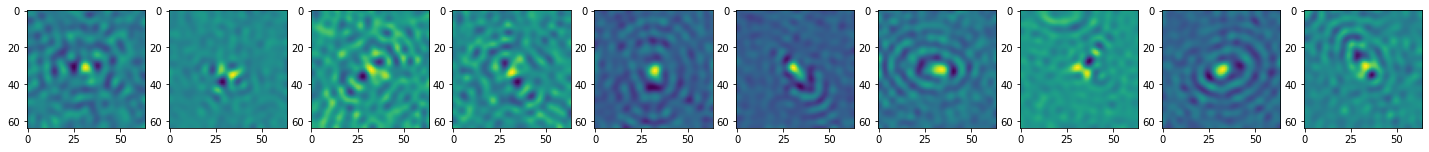

8


  0%|          | 0/10 [00:00<?, ?it/s]

Generating 100 / 100 samples before starting training


 10%|█         | 1/10 [00:42<06:25, 42.83s/it]

Generating 101 / 100 samples before starting training


 20%|██        | 2/10 [01:04<04:00, 30.10s/it]

Generating 100 / 100 samples before starting training


 30%|███       | 3/10 [01:25<03:02, 26.07s/it]

Generating 100 / 100 samples before starting training


 40%|████      | 4/10 [01:41<02:14, 22.37s/it]

Generating 101 / 100 samples before starting training


 50%|█████     | 5/10 [02:00<01:44, 20.87s/it]

Generating 100 / 100 samples before starting training


 60%|██████    | 6/10 [02:18<01:20, 20.14s/it]

Generating 100 / 100 samples before starting training


 70%|███████   | 7/10 [02:37<00:58, 19.50s/it]

Generating 101 / 100 samples before starting training


 80%|████████  | 8/10 [02:55<00:38, 19.13s/it]

Generating 100 / 100 samples before starting training


 90%|█████████ | 9/10 [03:17<00:20, 20.06s/it]

Generating 101 / 100 samples before starting training


In [ ]:
crop_size = 64
padding = 16
wavelength = 525e-9
pixel_size = 114e-9
num_outputs=3
image_size=64
delta_time = 1/41
num_layers = 2

drive.mount('/content/drive')
filenames = !ls 'drive/My Drive/ny data från Erik'
filenames = [filename for filename in filenames if (".mat" in filename and "wGold" in filename)]

list_of_models = []
for _ in range(no_tiles):
  list_of_models.append(create_model(CustomLayer(), num_layers, image_size))

for filename in filenames: 
    file_path = "/content/drive/My Drive/ny data från Erik/" + filename
    data = scipy.io.loadmat(file_path)['CompletedTraces']
    print(f"Loading file: {filename}", end=" ")
    data = data[..., :300]
    particles_positions, particles_timeseries = extract_pos_and_images(data)
    particles_positions_seg, particles_timeseries_seg  = segment_exp_data(particles_positions, particles_timeseries)
    group, equivariance = create_group(crop_size=crop_size, padding=padding, wavelength=wavelength, pixel_size=114e-9)

    for i, (timeseries_tile, position_tile) in enumerate(zip(particles_timeseries_seg, particles_positions_seg)):
      print(f"Training model {i}")
      plot_dataset(create_training_set(timeseries_tile), group, nrows=1)
      train_on_particle(list_of_models[i], timeseries_tile)

    print(f"Creating corrected traces", end=" ")
    traces_matlab, traces_lode, z_mults = compare_lode_matlab(list_of_models, particles_timeseries, particles_positions, verbose=0)
    calculate_diffusion([x[0]+x[1] for x in zip(traces_matlab, traces_lode)])